# POC Loan Rates Forecast Model

## 4.1. Data Engineering

### 4.1.1. Data Collection

#### Setup

In [2]:
# System libraries
import glob

# ML libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import coint
from arch.unitroot import PhillipsPerron, DFGLS
import xgboost as xgb
from numpy import argmax
from sklearn.metrics import accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Load FRED Data

In [7]:
from validmind.datasets.regression import fred as demo_dataset

target_column = demo_dataset.target_column
feature_columns = demo_dataset.feature_columns

# Split the dataset into test and training 
df = demo_dataset.load_data()
df.tail(10)


,MORTGAGE30US,FEDFUNDS,GS10,UNRATE
DATE,,,,
2023-03-02,6.65,NaN,NaN,NaN
2023-03-09,6.73,NaN,NaN,NaN
2023-03-16,6.60,NaN,NaN,NaN
2023-03-23,6.42,NaN,NaN,NaN
2023-03-30,6.32,NaN,NaN,NaN
2023-04-01,NaN,NaN,3.46,NaN
2023-04-06,6.28,NaN,NaN,NaN
2023-04-13,6.27,NaN,NaN,NaN
2023-04-20,6.39,NaN,NaN,NaN


Plot time series.

In [8]:
def plot_time_series(df, cols_to_plot=None, title=''):
    """
    Plot multiple time-series in the same axes using seaborn.

    :param df: DataFrame with time-series data
    :param cols_to_plot: List of column names to plot. If None, plot all columns in df.
    :param title: Title of the plot, default is ''
    """
    if cols_to_plot is None:
        cols_to_plot = df.columns.tolist()

    # Create a new DataFrame with the columns to plot
    plot_df = df[cols_to_plot]

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the time-series data
    plt.figure(figsize=(12, 6))
    for col in plot_df.columns:
        sns.lineplot(data=plot_df[col], label=col)

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()


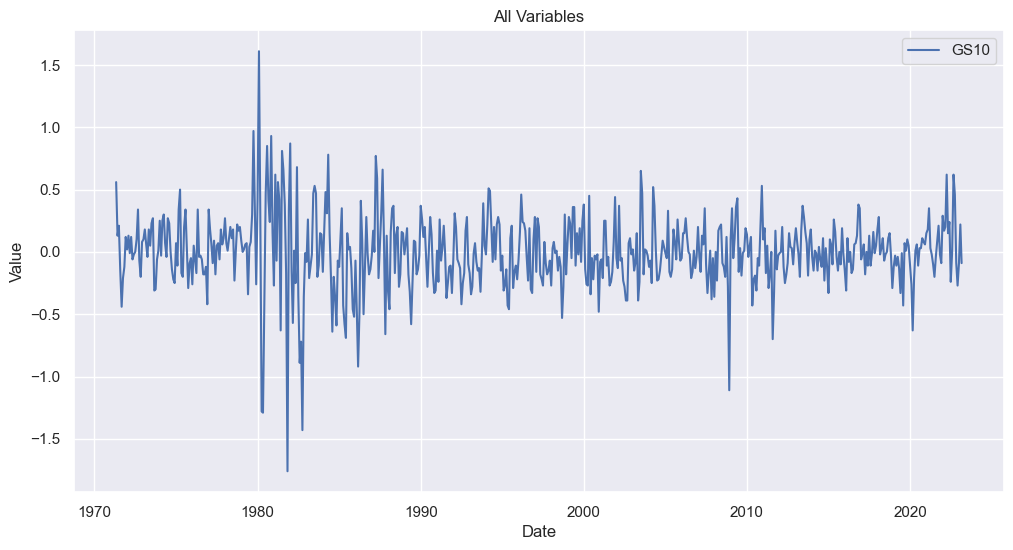

In [31]:
plot_time_series(df_diff[['GS10']], title='All Variables')

### 4.1.2. Data Description

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3551 entries, 1947-01-01 to 2023-04-27
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MORTGAGE30US  2718 non-null   float64
 1   FEDFUNDS      825 non-null    float64
 2   GS10          841 non-null    float64
 3   UNRATE        903 non-null    float64
dtypes: float64(4)
memory usage: 138.7 KB


### 4.1.3. Data Quality

#### Frequency of Series 

Distribution of frequencies in the data.

In [11]:
def plot_time_difference_frequency(df):
    # Calculate the time differences between consecutive entries
    time_diff = df.index.to_series().diff().dropna()

    # Convert the time differences to a suitable unit (e.g., days)
    time_diff_days = time_diff.dt.total_seconds() / (60 * 60 * 24)

    # Create a DataFrame with the time differences
    time_diff_df = pd.DataFrame({'Time Differences (Days)': time_diff_days})

    # Plot the frequency distribution of the time differences
    sns.histplot(data=time_diff_df, x='Time Differences (Days)', bins=50, kde=False)
    plt.xlabel('Time Differences (Days)')
    plt.ylabel('Frequency')
    plt.show()

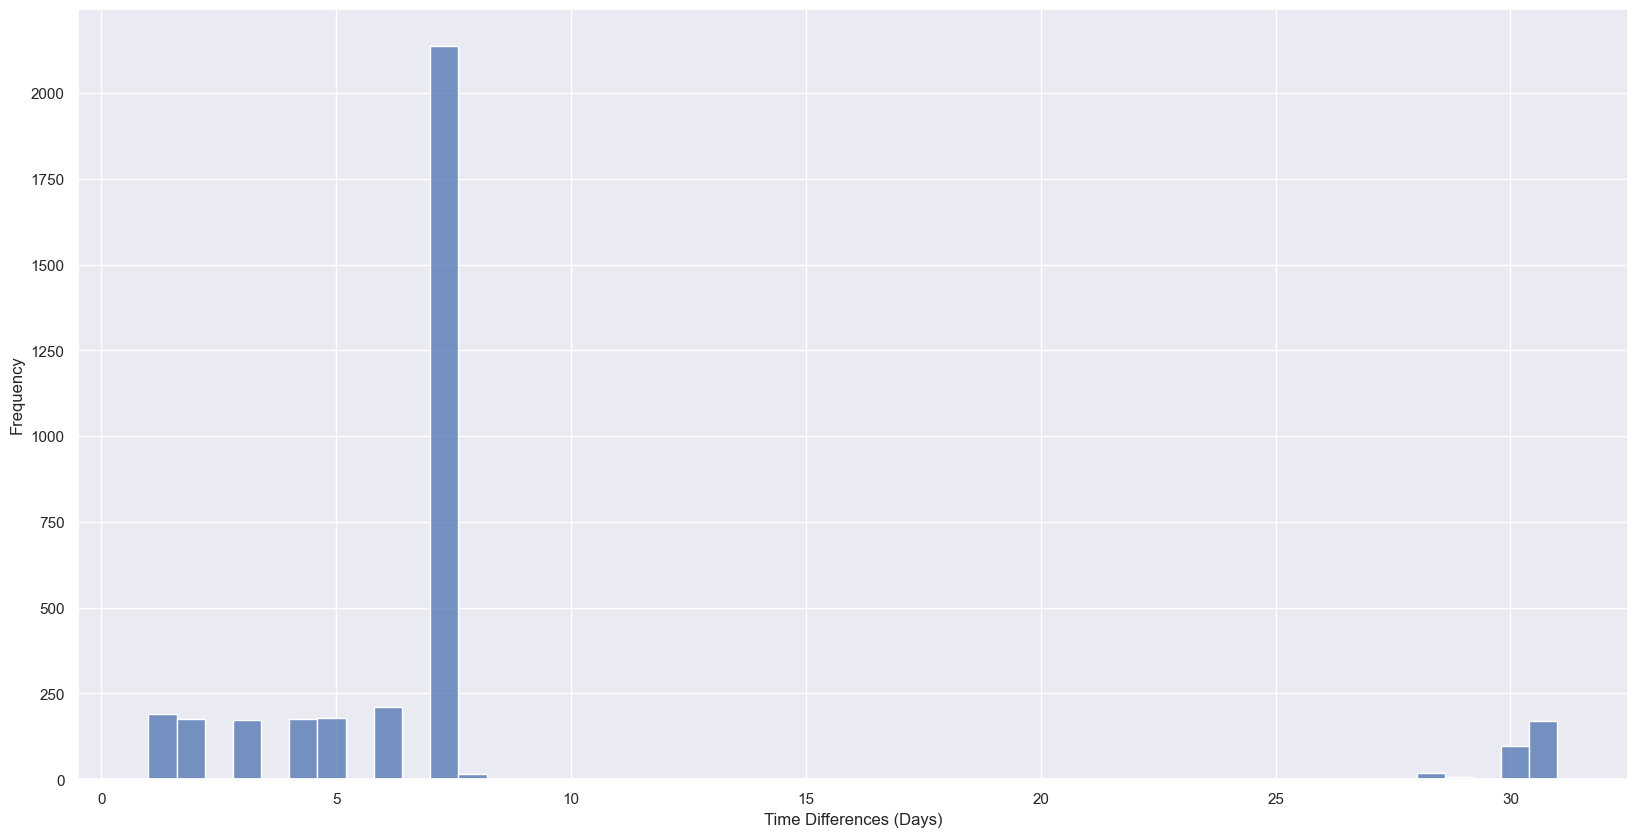

In [12]:
plot_time_difference_frequency(df)

Identify frequencies for each variable.

In [13]:
def identify_frequencies(df):
    """
    Identify the frequency of each series in the DataFrame.

    :param df: Time-series DataFrame
    :return: DataFrame with two columns: 'Variable' and 'Frequency'
    """
    frequencies = []
    for column in df.columns:
        series = df[column].dropna()
        if not series.empty:
            freq = pd.infer_freq(series.index)
            if freq == 'MS' or freq == 'M':
                label = 'Monthly'
            elif freq == 'Q':
                label = 'Quarterly'
            elif freq == 'A':
                label = 'Yearly'
            else:
                label = freq
        else:
            label = None

        frequencies.append({'Variable': column, 'Frequency': label})

    freq_df = pd.DataFrame(frequencies)

    return freq_df

In [14]:
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,None
1,FEDFUNDS,Monthly
2,GS10,Monthly
3,UNRATE,Monthly


Handling frequencies.

In [15]:
df = df.resample('MS').last()
frequencies = identify_frequencies(df)
display(frequencies)

,Variable,Frequency
0,MORTGAGE30US,Monthly
1,FEDFUNDS,Monthly
2,GS10,Monthly
3,UNRATE,Monthly


#### Missing Values

**Step 1: Identify Missing Values**

Total number of missing values.

In [16]:
def plot_missing_values_bar(df):
    """
    Plot a bar chart displaying the total number of missing values per variable (column) in a time-series DataFrame using seaborn.
    
    :param df: Time-series DataFrame
    """
    # Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Variables (Columns)')
    plt.ylabel('Number of Missing Values')
    plt.title('Total Number of Missing Values per Variable')
    plt.show()

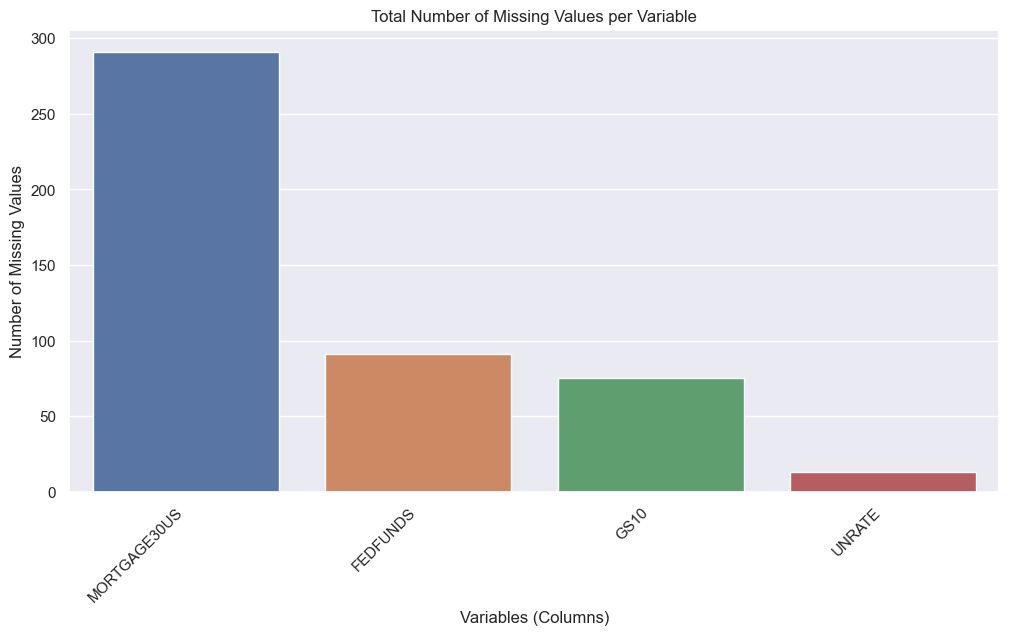

In [17]:
plot_missing_values_bar(df)

Heatmap of missing values.

In [18]:
def plot_missing_values_heatmap(df, start_year=None, end_year=None):
    """
    Plot a heatmap of missing values with actual years in rows using seaborn.

    :param df: Time-series DataFrame
    :param start_year: Start year for zooming in, defaults to None
    :param end_year: End year for zooming in, defaults to None
    """
    # Filter the DataFrame based on the specified start_year and end_year
    if start_year:
        df = df[df.index.year >= start_year]
    if end_year:
        df = df[df.index.year <= end_year]

    # Create a boolean mask for missing values
    missing_mask = df.isnull()

    # Set seaborn plot style
    sns.set(style="darkgrid")

    # Plot the heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(missing_mask.T, cmap='viridis', cbar=False, xticklabels=False)

    # Add actual years on the x-axis
    years = df.index.year.unique()
    xticks = [df.index.get_loc(df.index[df.index.year == year][0]) for year in years]
    plt.xticks(xticks, years, rotation=45, ha='right')

    plt.ylabel('Columns')
    plt.xlabel('Rows (Years)')
    plt.title('Missing Values Heatmap with Actual Years in Rows')
    plt.show()

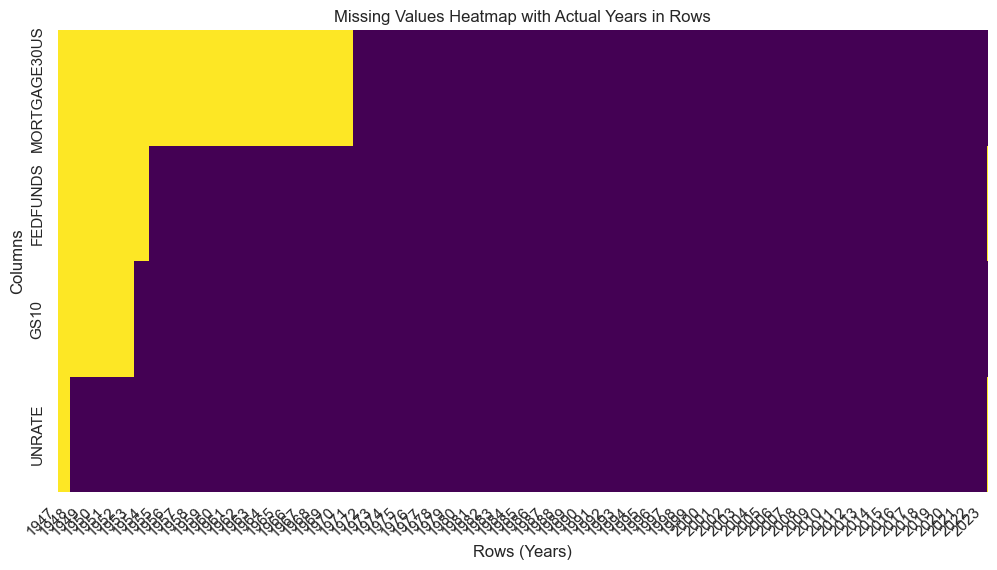

In [19]:
plot_missing_values_heatmap(df)

**Step 2: Handling Missing Values**

Drop missing values.

In [ ]:
df = df.dropna()

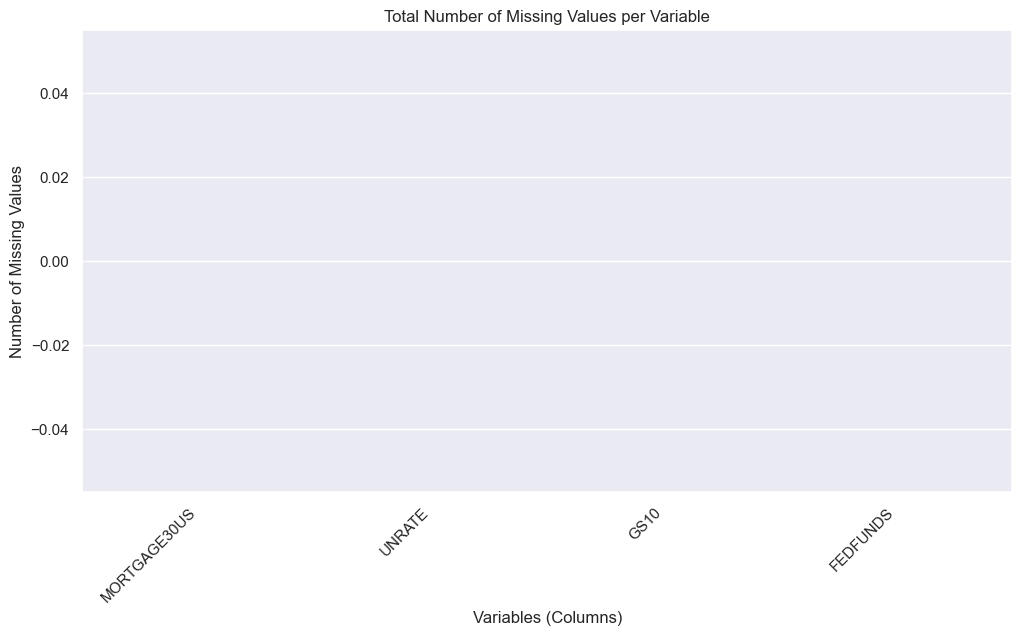

In [ ]:
plot_missing_values_bar(df)

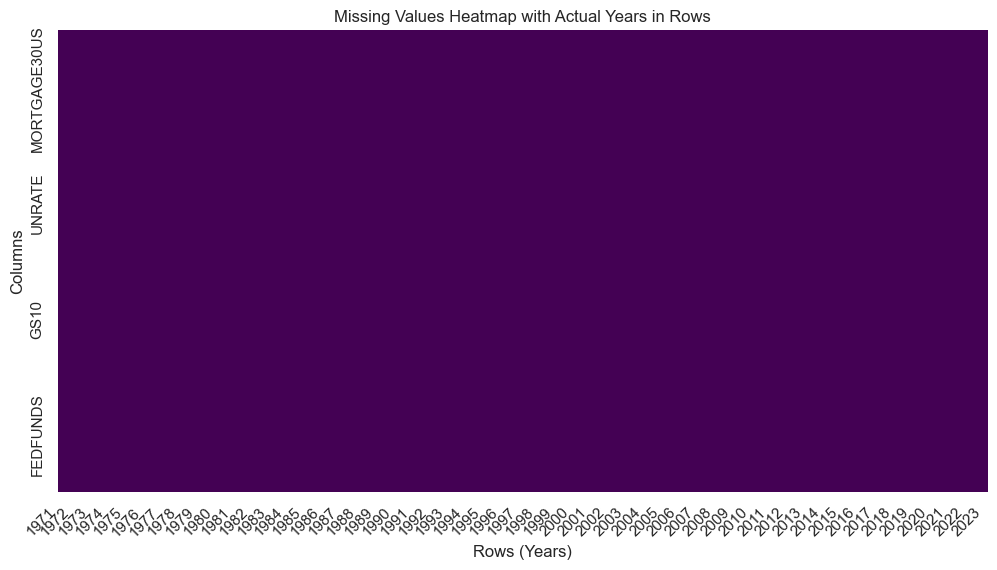

In [ ]:
plot_missing_values_heatmap(df)

#### Outliers

**Step 1: Identify Outliers**

In [20]:
def identify_outliers(df, threshold=3):
    z_scores = pd.DataFrame(stats.zscore(df), index=df.index, columns=df.columns)
    outliers = z_scores[(z_scores.abs() > threshold).any(axis=1)]
    
    outlier_table = []
    for idx, row in outliers.iterrows():
        for col in df.columns:
            if abs(row[col]) > threshold:
                outlier_table.append({"Variable": col, "z-score": row[col], "Threshold": threshold, "Date": idx})
                
    return pd.DataFrame(outlier_table)


In [21]:
outliers_table = identify_outliers(df, threshold=3)
display(outliers_table)

""


Plot outliers.

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_outliers(df, outliers_table, use_subplots=False):
    sns.set(style="darkgrid")
    
    if use_subplots:
        n_variables = len(df.columns)
        fig, axes = plt.subplots(n_variables, 1, figsize=(12, 3 * n_variables), sharex=True)
        
        for i, col in enumerate(df.columns):
            sns.lineplot(data=df, x=df.index, y=col, ax=axes[i], label=col)
            
            variable_outliers = outliers_table[outliers_table["Variable"] == col]
            for idx, row in variable_outliers.iterrows():
                date = row["Date"]
                outlier_value = df.loc[date, col]
                axes[i].scatter(date, outlier_value, marker="o", s=100, c="red", label="Outlier" if idx == 0 else "")
            
            axes[i].legend()
            axes[i].set_ylabel("Value")
            axes[i].set_title(f"Time Series with Outliers for {col}")

        plt.xlabel("Date")
        plt.tight_layout()

    else:
        plt.figure(figsize=(12, 3))
        for col in df.columns:
            sns.lineplot(data=df, x=df.index, y=col, label=col)
        
        plotted_outlier_variables = set()
        for idx, row in outliers_table.iterrows():
            date = row["Date"]
            variable = row["Variable"]
            outlier_value = df.loc[date, variable]
            if variable not in plotted_outlier_variables:
                plt.scatter(date, outlier_value, marker="o", s=100, c="red", label=f"Outlier ({variable})")
                plotted_outlier_variables.add(variable)
            else:
                plt.scatter(date, outlier_value, marker="o", s=100, c="red")

        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Time Series with Outliers")
    
    plt.show()


KeyError: 'Variable'

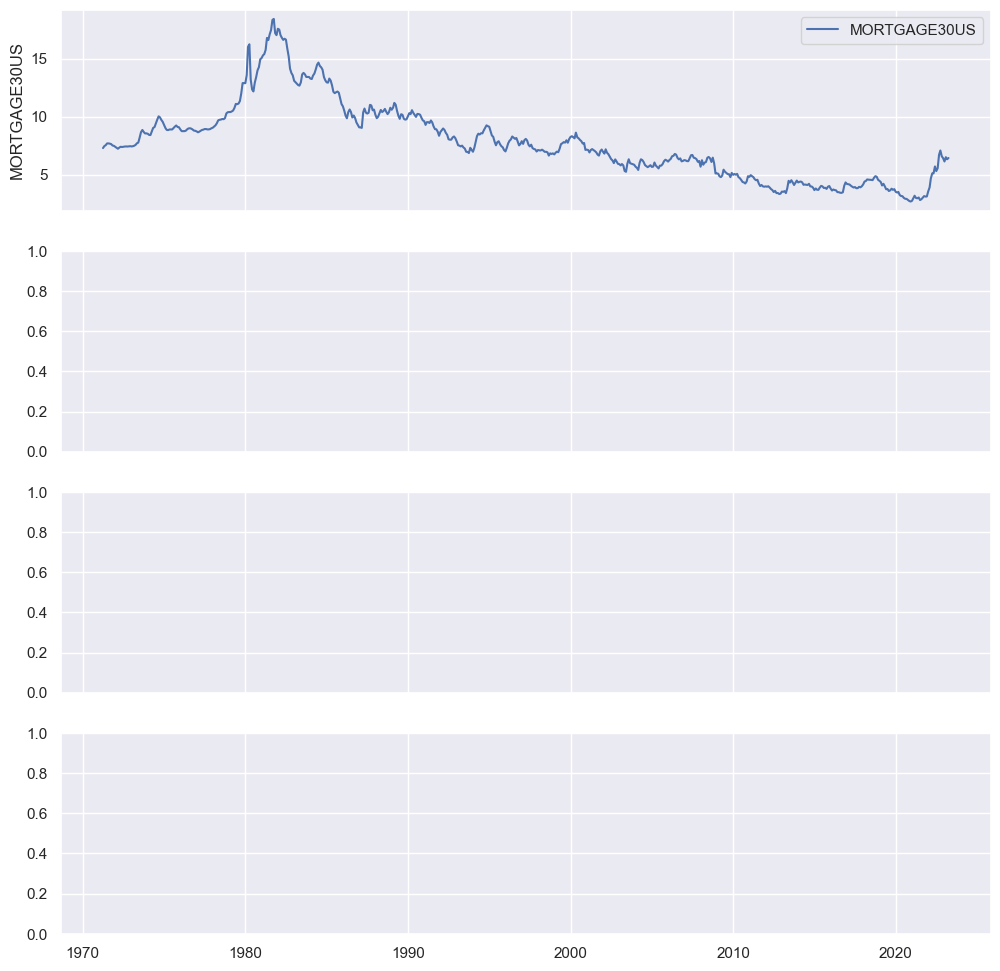

In [23]:
plot_outliers(df, outliers_table, use_subplots=True)

**Step 2: Handling Outliers**

## 4.2. Exploratory Data Analysis

### 4.2.1. Univariate Analysis

#### Visual Inspection

Line plots.

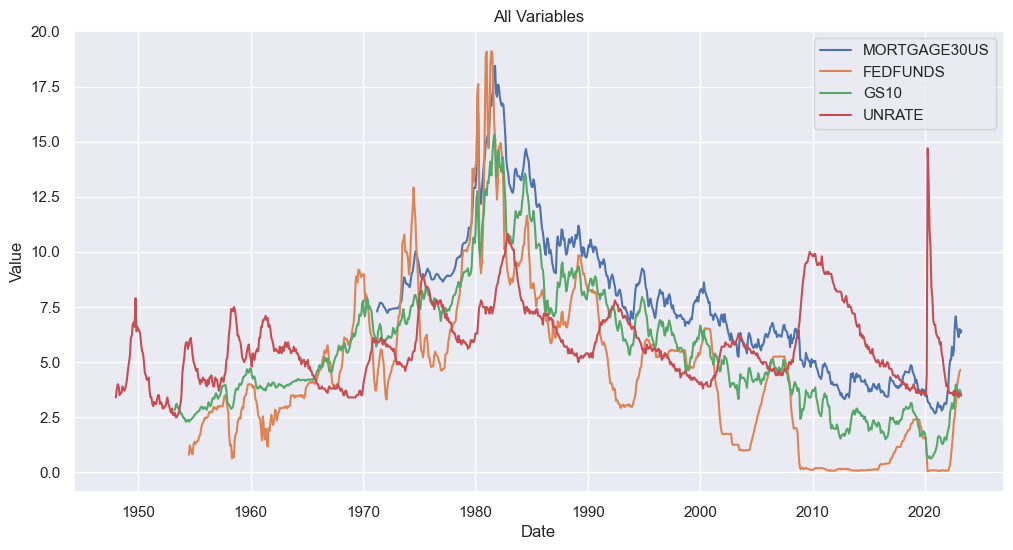

In [24]:
plot_time_series(df, title='All Variables')

#### Seasonality 

**Step 1: Compute Seasonal Decomposition**

In [ ]:
def compute_seasonal_decomposition(data, model='additive'):
    """
    Compute seasonal decomposition for all time-series in a DataFrame and store all the components in a new DataFrame.
    
    :param data: DataFrame with time-series data
    :param period: Number of observations in each seasonal period
    :return: DataFrame with seasonal, trend, and residual components for all time-series in the input DataFrame
    """
    # Initialize an empty DataFrame to store the components for each time-series
    decomp_df = pd.DataFrame()

    # Loop over each column in the input DataFrame and perform seasonal decomposition
    for col in data.columns:
        res = seasonal_decompose(data[col], model=model)
        decomp_df[f'{col}_seasonal'] = res.seasonal
        decomp_df[f'{col}_trend'] = res.trend
        decomp_df[f'{col}_residual'] = res.resid

    # Set the index of the decomposed DataFrame to be the same as the input DataFrame
    decomp_df.index = data.index

    return decomp_df


In [ ]:
decomp_df = compute_seasonal_decomposition(df)

**Step 2: Visualize Seasonal Decomposition**

In [ ]:
def plot_seasonal_components(decomp_df):
    """
    Plot all seasonal, trend, and residual components for each variable in a DataFrame.
    
    :param decomp_df: DataFrame with seasonal, trend, and residual components for each variable
    """
    # Initialize a figure with subplots for each variable and component
    fig, axs = plt.subplots(nrows=len(decomp_df.columns) // 3, ncols=3, figsize=(12, 4 * (len(decomp_df.columns) // 3)))

    # Loop over each variable in the input DataFrame and plot the seasonal, trend, and residual components
    for i, col in enumerate(decomp_df.columns[::3]):
        axs[i, 0].plot(decomp_df.index, decomp_df[f'{col}'])
        axs[i, 0].set_title(f'Seasonal: {col[:-9]}')
        axs[i, 1].plot(decomp_df.index, decomp_df[f'{col[:-9]}_trend'])
        axs[i, 1].set_title(f'Trend: {col[:-9]}')
        axs[i, 2].plot(decomp_df.index, decomp_df[f'{col[:-9]}_residual'])
        axs[i, 2].set_title(f'Residual: {col[:-9]}')

    # Set the figure title
    fig.suptitle('Seasonal Decomposition', fontsize=16)

    # Adjust the spacing between subplots
    fig.tight_layout()

    # Show the plot
    plt.show()

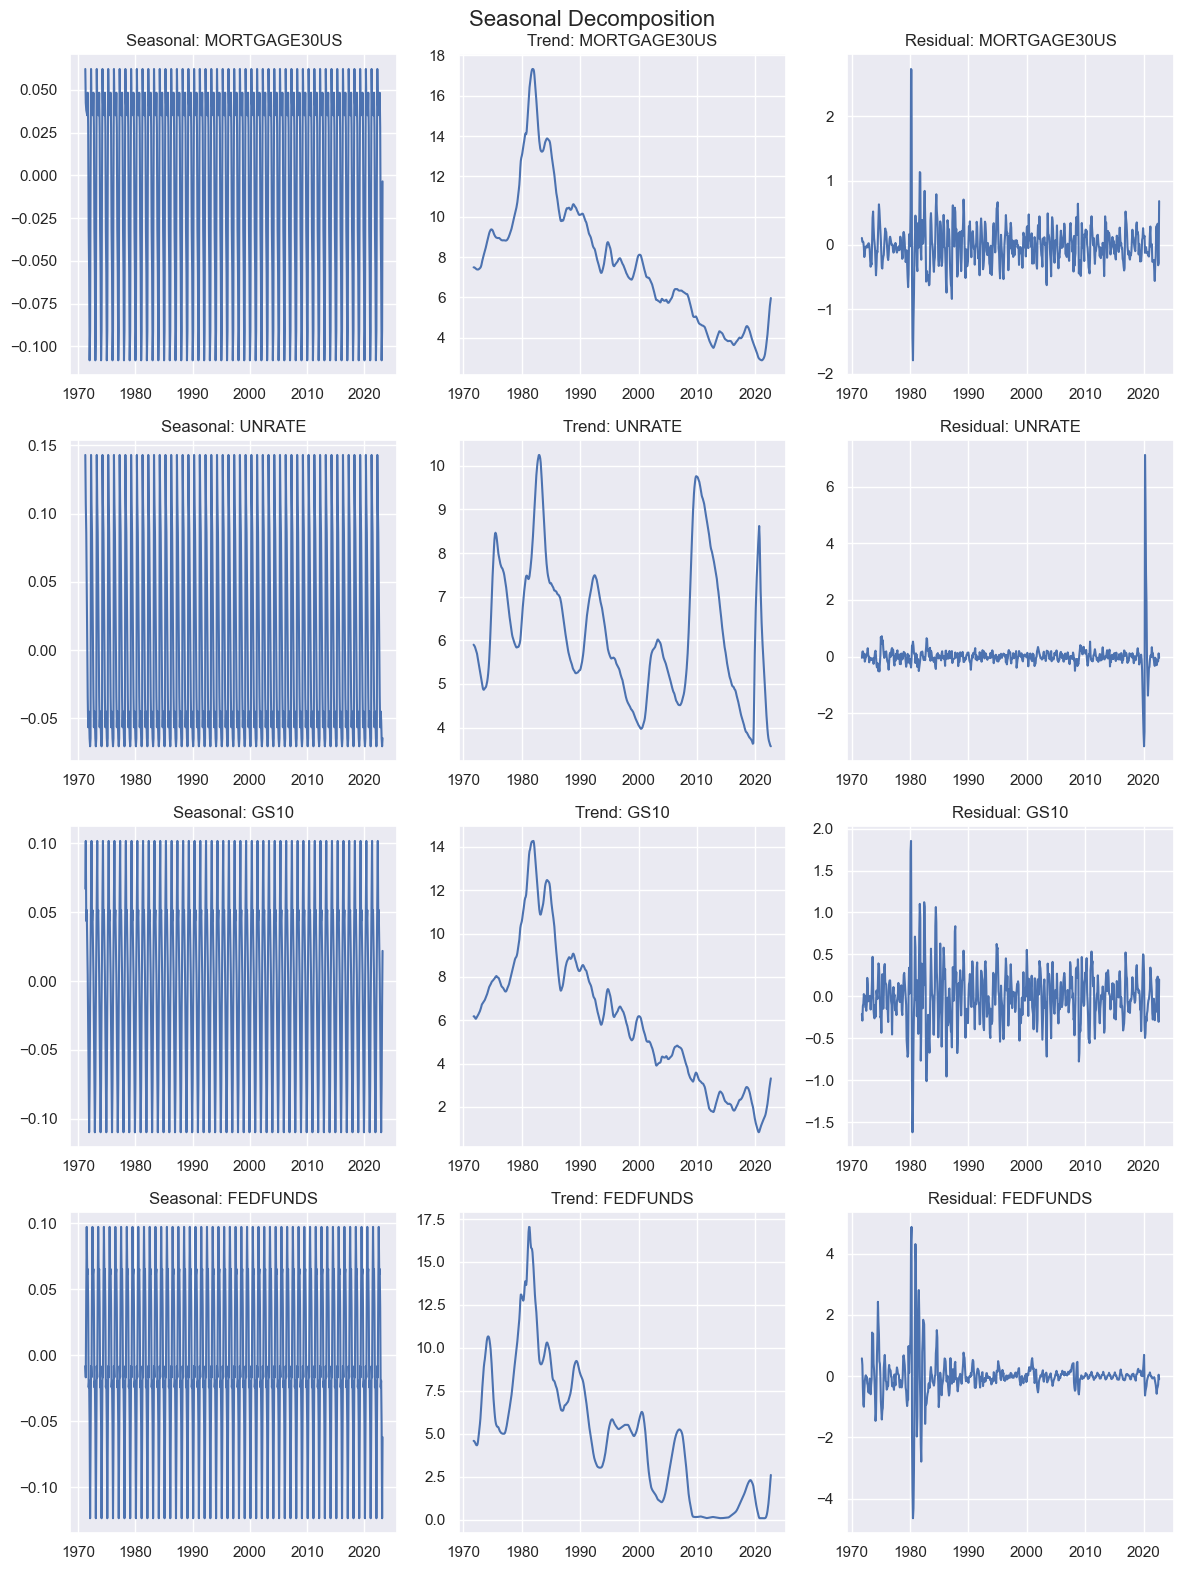

In [ ]:
plot_seasonal_components(decomp_df)

**Step 3: Residual Analysis**

#### Stationarity

**Step 1: Auto Stationarity**

In [ ]:
def test_stationarity(data, threshold=0.05):
    """
    Perform multiple stationarity tests on each time series in a DataFrame.
    
    :param data: DataFrame with time-series data
    :return: DataFrame with test results (Variable, Test, p-value, Threshold, Pass/Fail, Decision)
    """
    # Initialize an empty DataFrame to store the test results
    test_results = pd.DataFrame(columns=['Variable', 'Test', 'p-value', 'Threshold', 'Pass/Fail', 'Decision'])

    # Loop over each column in the input DataFrame and perform stationarity tests
    for col in data.columns:
        # Perform the ADF test
        adf_result = adfuller(data[col], autolag='AIC')
        adf_pvalue = adf_result[1]
        adf_pass_fail = adf_pvalue < threshold
        adf_decision = 'Stationary' if adf_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'ADF',
            'p-value': adf_pvalue,
            'Threshold': threshold,
            'Pass/Fail': adf_pass_fail,
            'Decision': adf_decision
        }, ignore_index=True)

        # Perform the KPSS test
        kpss_result = kpss(data[col], regression='c', nlags='auto')
        kpss_pvalue = kpss_result[1]
        kpss_pass_fail = kpss_pvalue > threshold
        kpss_decision = 'Stationary' if kpss_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'KPSS',
            'p-value': kpss_pvalue,
            'Threshold': threshold,
            'Pass/Fail': kpss_pass_fail,
            'Decision': kpss_decision
        }, ignore_index=True)

        # Perform the Phillips-Perron test
        pp_result = PhillipsPerron(data[col], trend='ct')
        pp_pvalue = pp_result.pvalue
        pp_threshold = threshold
        pp_pass_fail = pp_pvalue < pp_threshold
        pp_decision = 'Stationary' if pp_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'PhillipsPerron',
            'p-value': pp_pvalue,
            'Threshold': pp_threshold,
            'Pass/Fail': pp_pass_fail,
            'Decision': pp_decision
        }, ignore_index=True)

        # Perform the DF-GLS test
        dfgls_result = DFGLS(data[col], trend='ct')
        dfgls_pvalue = dfgls_result.pvalue
        dfgls_threshold = threshold
        dfgls_pass_fail = dfgls_pvalue < dfgls_threshold
        dfgls_decision = 'Stationary' if dfgls_pass_fail else 'Non-stationary'
        test_results = test_results.append({
            'Variable': col,
            'Test': 'DFGLS',
            'p-value': dfgls_pvalue,
            'Threshold': dfgls_threshold,
            'Pass/Fail': dfgls_pass_fail,
            'Decision': dfgls_decision
        }, ignore_index=True)

    return test_results


In [ ]:
def auto_stationarity(data, max_order=5, threshold=0.05):
    """
    Perform the Augmented Dickey-Fuller (ADF) stationarity test on each time series in a DataFrame,
    testing for different integration orders until the series is stationary.
    
    :param data: DataFrame with time-series data
    :param max_order: Maximum integration order to test
    :param threshold: Significance level for the ADF test
    :return: DataFrame with test results (Variable, Integration Order, Test, p-value, Threshold, Pass/Fail, Decision)
    """
    # Initialize an empty DataFrame to store the test results
    test_results = pd.DataFrame(columns=['Variable', 'Integration Order', 'Test', 'p-value', 'Threshold', 'Pass/Fail', 'Decision'])

    # Loop over each column in the input DataFrame and perform stationarity tests
    for col in data.columns:
        is_stationary = False
        order = 0
        
        while not is_stationary and order <= max_order:
            series = data[col]
            
            if order == 0:
                adf_result = adfuller(series)
            else:
                adf_result = adfuller(np.diff(series, n=order-1))

            adf_pvalue = adf_result[1]
            adf_pass_fail = adf_pvalue < threshold
            adf_decision = 'Stationary' if adf_pass_fail else 'Non-stationary'

            test_results = test_results.append({
                'Variable': col,
                'Integration Order': order,
                'Test': 'ADF',
                'p-value': adf_pvalue,
                'Threshold': threshold,
                'Pass/Fail': 'Pass' if adf_pass_fail else 'Fail',
                'Decision': adf_decision
            }, ignore_index=True)

            if adf_pass_fail:
                is_stationary = True
            
            order += 1

    return test_results

In [ ]:
auto_stationarity(df)

,Variable,Integration Order,Test,p-value,Threshold,Pass/Fail,Decision
0,MORTGAGE30US,0,ADF,6.719476e-01,0.05,Fail,Non-stationary
1,MORTGAGE30US,1,ADF,6.719476e-01,0.05,Fail,Non-stationary
2,MORTGAGE30US,2,ADF,2.156453e-30,0.05,Pass,Stationary
3,UNRATE,0,ADF,1.939529e-02,0.05,Pass,Stationary
4,GS10,0,ADF,7.099537e-01,0.05,Fail,Non-stationary
5,GS10,1,ADF,7.099537e-01,0.05,Fail,Non-stationary
6,GS10,2,ADF,2.036674e-09,0.05,Pass,Stationary
7,FEDFUNDS,0,ADF,1.058010e-01,0.05,Fail,Non-stationary
8,FEDFUNDS,1,ADF,1.058010e-01,0.05,Fail,Non-stationary
9,FEDFUNDS,2,ADF,6.632874e-05,0.05,Pass,Stationary


**Step 2: Rolling Statistics**

In [ ]:
def plot_rolling_statistics(df, window_size=12):
    """
    Plot rolling mean and rolling standard deviation in different subplots for each variable.
    
    :param df: DataFrame with time-series data
    :param window_size: Window size for the rolling calculations
    """
    for col_name in df.columns:
        rolling_mean = df[col_name].rolling(window=window_size).mean()
        rolling_std = df[col_name].rolling(window=window_size).std()

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))

        ax1.plot(rolling_mean, label=f'{col_name} Rolling Mean')
        ax1.legend()
        ax1.set_ylabel('Value')
        ax1.set_title(f'Rolling Mean for {col_name}')

        ax2.plot(rolling_std, label=f'{col_name} Rolling Standard Deviation', color='orange')
        ax2.legend()
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Value')
        ax2.set_title(f'Rolling Standard Deviation for {col_name}')

        plt.show()


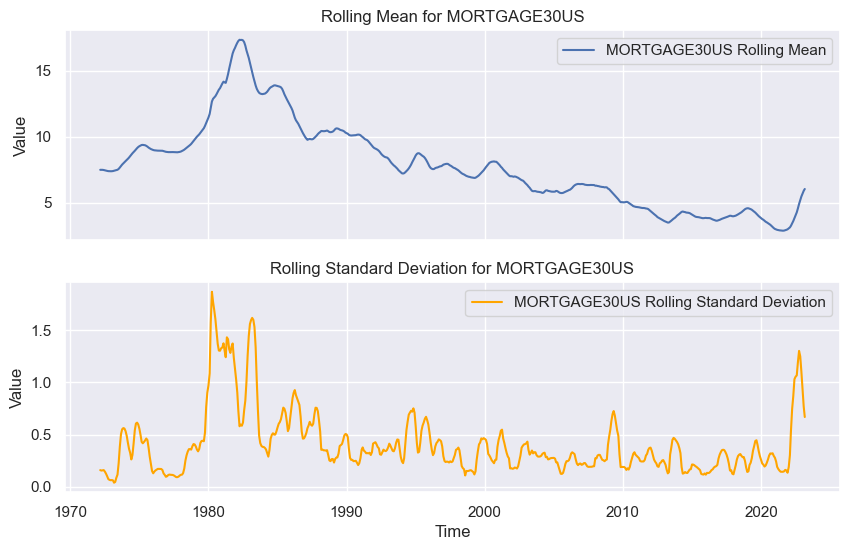

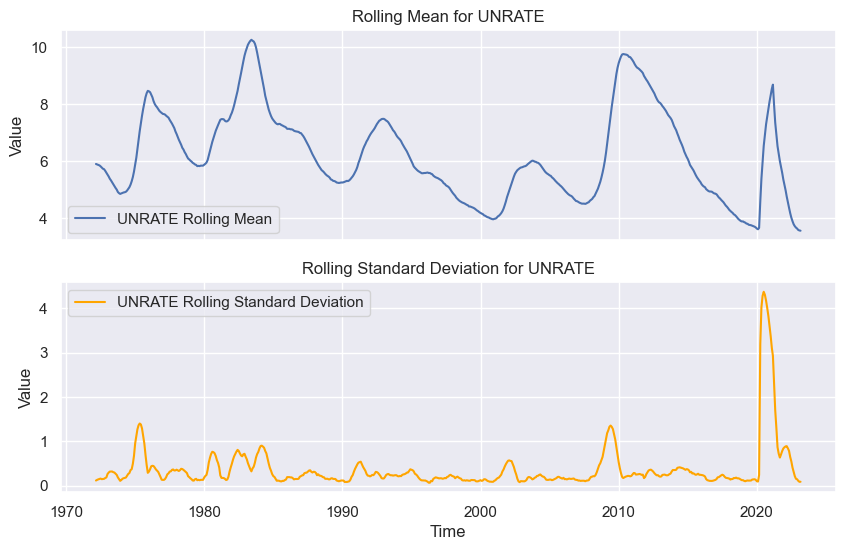

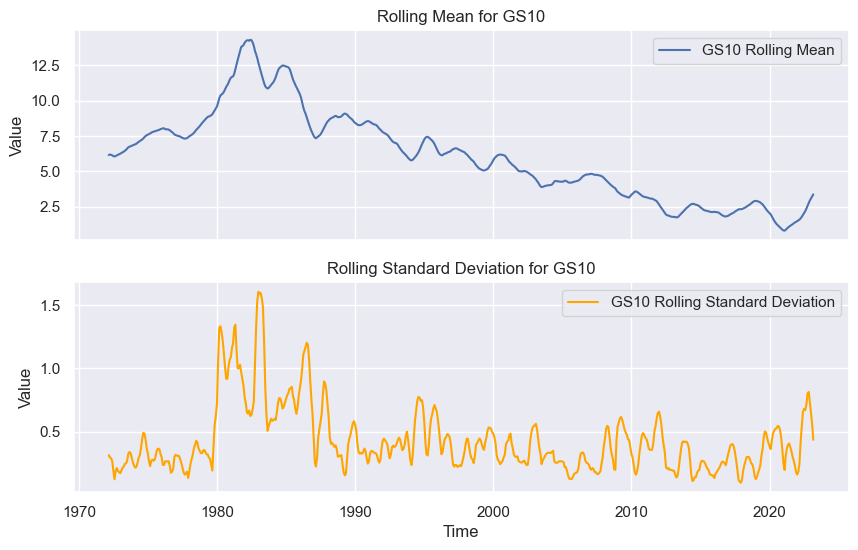

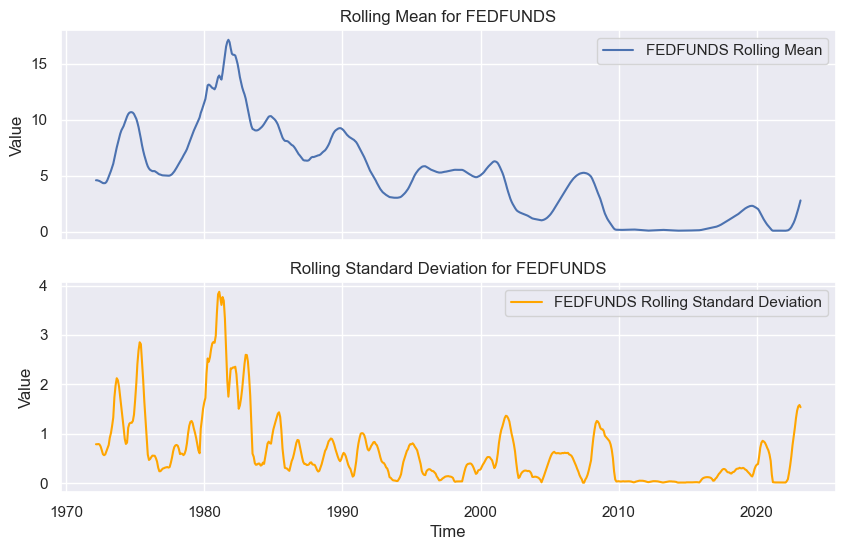

In [ ]:
plot_rolling_statistics(df)

In [25]:
df_diff = df.diff().dropna()

#### AR Analysis

**Step 1: Calculate AR Orders**

In [ ]:
def calculate_ar_orders(dataset, max_order=3):
    """
    This function calculates the autoregressive order of all time series in a dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset containing the time series.
    max_order (int): The maximum order to consider for the autoregressive models.
    
    Returns:
    pd.DataFrame: A table with the autoregressive order, AIC, and BIC for orders 0 up to max_order.
    """
    # Initialize an empty list to store the results
    results = []

    # Iterate over each column (time series) in the dataset
    for col in dataset.columns:
        time_series = dataset[col]
        
        # Test for stationarity using Augmented Dickey-Fuller test
        adf_result = adfuller(time_series)
        if adf_result[1] > 0.05:
            time_series = time_series.diff().dropna()  # Apply first difference to make the series stationary
        
        # Test different autoregressive orders and store the AIC and BIC values
        for order in range(max_order + 1):
            model = AutoReg(time_series, lags=order, old_names=False)
            result = model.fit()
            
            # Add the current time series, order, AIC, and BIC to the results list
            results.append({'Variable': col, 'AR order': order, 'AIC': result.aic, 'BIC': result.bic})

    # Convert the results list to a DataFrame and return it
    return pd.DataFrame(results)

In [ ]:
calculate_ar_orders(df_diff)

,Variable,AR order,AIC,BIC
0,MORTGAGE30US,0,291.177506,300.046599
1,MORTGAGE30US,1,246.637029,259.935849
2,MORTGAGE30US,2,223.310101,241.035426
3,MORTGAGE30US,3,225.331792,247.480389
4,UNRATE,0,835.075578,843.944671
5,UNRATE,1,835.941726,849.240546
6,UNRATE,2,833.607234,851.332559
7,UNRATE,3,835.222318,857.370915
8,GS10,0,243.604950,252.474043
9,GS10,1,179.889575,193.188396


**Step 2: Selection of AR Order**

#### MA Analysis

**Step 1: Calculate MA Orders**

In [ ]:
def calculate_ma_orders(dataset, max_order=3):
    """
    This function calculates the moving average order of all time series in a dataset.
    
    Parameters:
    dataset (pd.DataFrame): The dataset containing the time series.
    max_order (int): The maximum order to consider for the moving average models.
    
    Returns:
    pd.DataFrame: A table with the moving average order, AIC, and BIC for orders 0 up to max_order.
    """
    # Initialize an empty list to store the results
    results = []

    # Iterate over each column (time series) in the dataset
    for col in dataset.columns:
        time_series = dataset[col]
        
        # Test for stationarity using Augmented Dickey-Fuller test
        adf_result = adfuller(time_series)
        if adf_result[1] > 0.05:
            time_series = time_series.diff().dropna()  # Apply first difference to make the series stationary
        
        # Test different moving average orders and store the AIC and BIC values
        for order in range(max_order + 1):
            model = ARIMA(time_series, order=(0, 0, order))
            result = model.fit()
            
            # Add the current time series, order, AIC, and BIC to the results list
            results.append({'Variable': col, 'MA order': order, 'AIC': result.aic, 'BIC': result.bic})

    # Convert the results list to a DataFrame and return it
    return pd.DataFrame(results)

In [ ]:
calculate_ma_orders(df_diff)

,Variable,MA order,AIC,BIC
0,MORTGAGE30US,0,291.177507,300.046600
1,MORTGAGE30US,1,228.313186,241.616825
2,MORTGAGE30US,2,227.394618,245.132804
3,MORTGAGE30US,3,225.782939,247.955672
4,UNRATE,0,835.075578,843.944671
5,UNRATE,1,836.126269,849.429909
6,UNRATE,2,833.512857,851.251043
7,UNRATE,3,835.509496,857.682228
8,GS10,0,243.604950,252.474043
9,GS10,1,155.604373,168.908013


**Step 2: Selection of MA Order**

### 4.2.2. Multivariate Analysis

#### Correlations

**Step 1: Compute Correlation Matrix on Levels**

In [ ]:
def plot_corr_heatmap(df):
    # Compute correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

    # Set plot title
    plt.title('Correlation Matrix Heatmap')

    # Show plot
    plt.show()


Corrrelations across Levels.

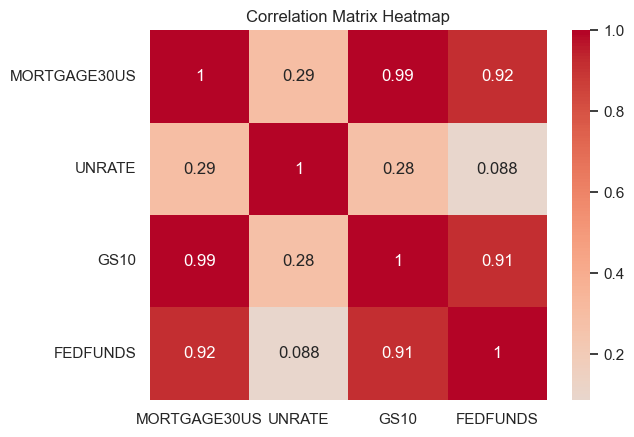

In [ ]:
plot_corr_heatmap(df)

**Step 2: Compute Correlation Matrix on First Difference**

Correlations across First Differences.

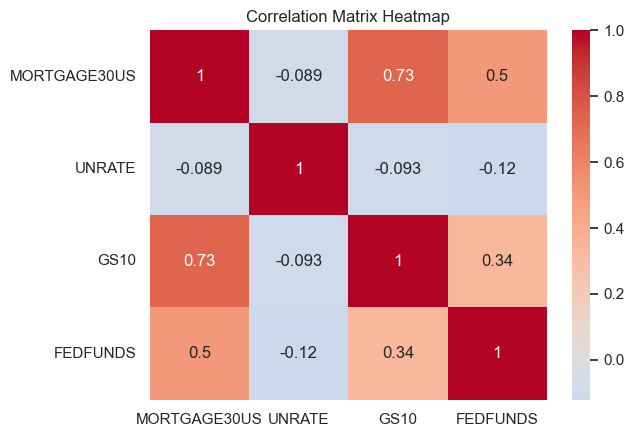

In [ ]:
plot_corr_heatmap(df_diff)

**Step 3: Reasoning**

#### Scatter Plots

**Step 1: Compute Scatter Plots on Levels**

In [ ]:
def plot_scatter_pairs(df):
    # Compute pairwise scatter plots
    sns.pairplot(df, kind='scatter')

    # Show plot
    plt.show()

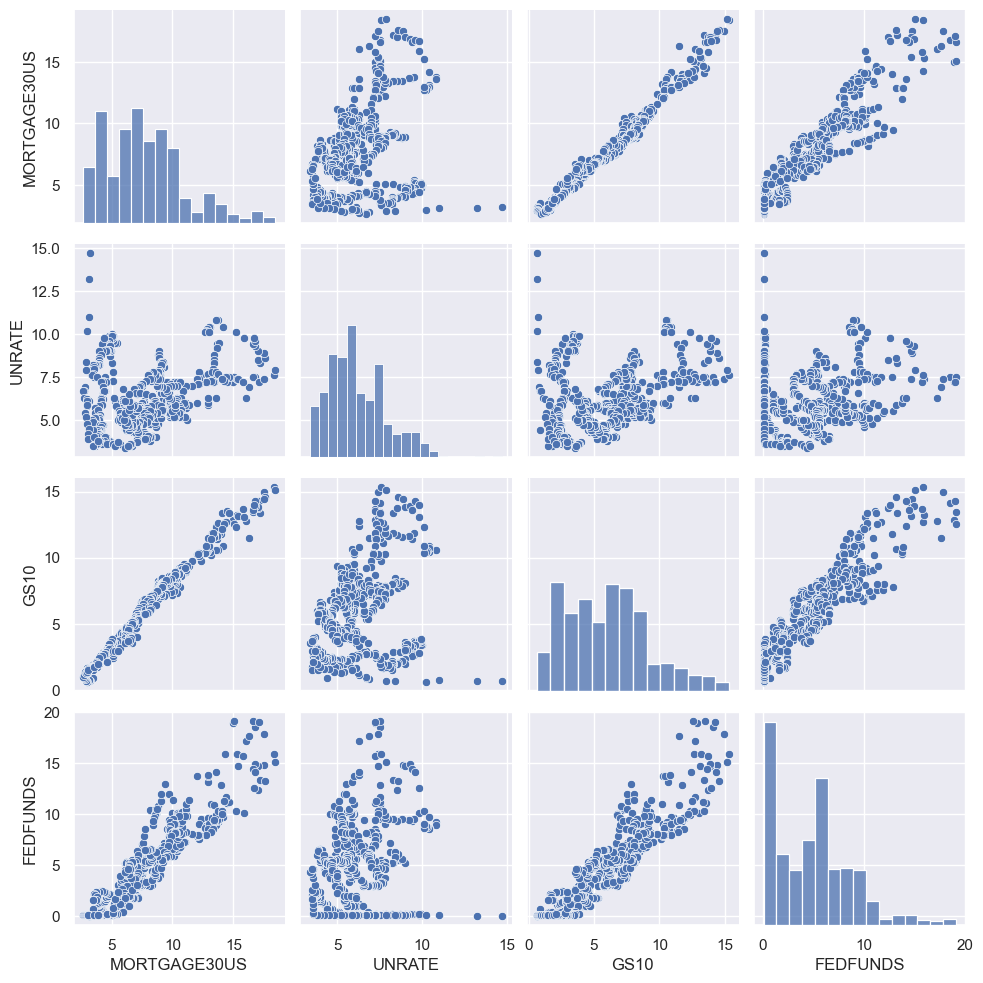

In [ ]:
plot_scatter_pairs(df)

**Step 2: Compute Scatter Plots on First Difference**

Compute first difference.

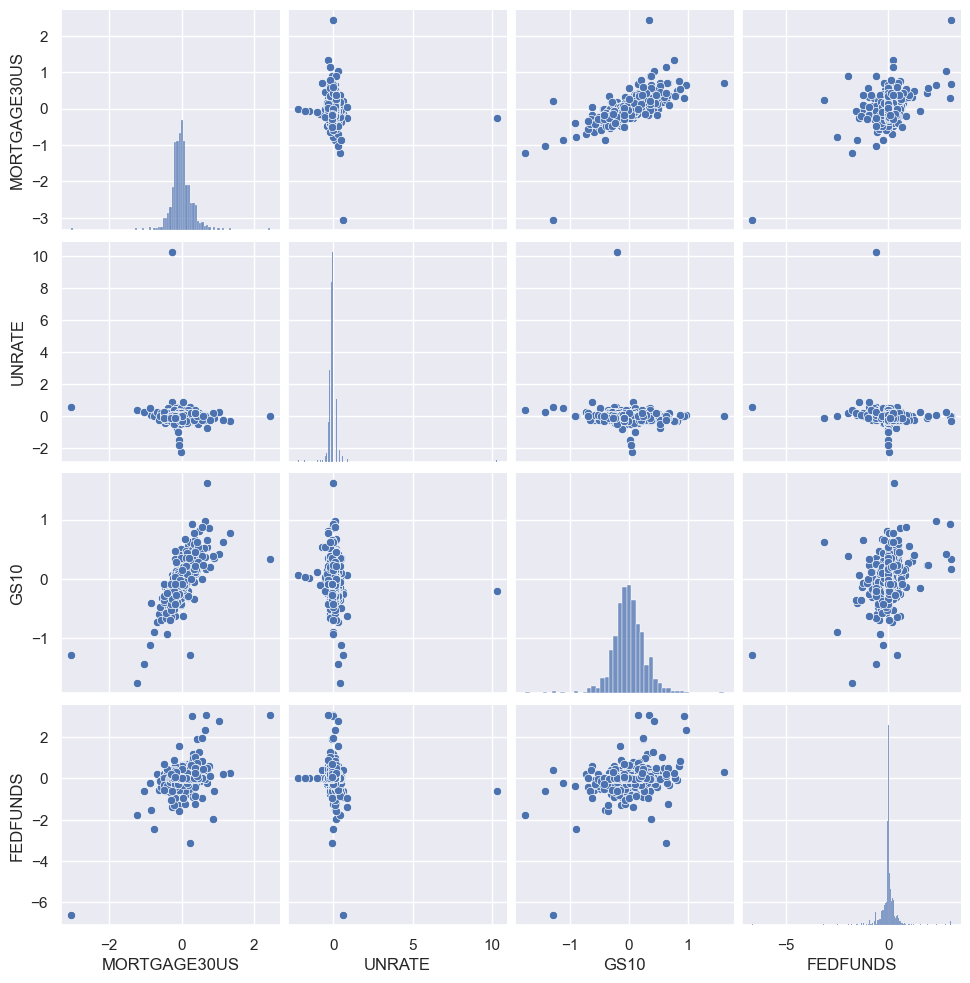

In [ ]:
plot_scatter_pairs(df_diff)

**Step 3: Reasoning**

#### Lag Analysis

**Step 1: Compute Correlations at Multiple Lags**

In [ ]:
def plot_heatmap_correlations(df, target_col, independent_vars, num_lags=10):
    """
    Calculate the correlation between the target variable and the lags of independent variables in the dataset,
    and plot a heatmap of these correlations.
    :param df: DataFrame containing the target variable and independent variables of interest
    :param target_col: Column name of the target variable in the DataFrame
    :param independent_vars: List of column names of the independent variables in the DataFrame
    :param num_lags: Number of lags to calculate (default is 10)
    """

    correlations = np.zeros((len(independent_vars), num_lags + 1))

    for i, ind_var_col in enumerate(independent_vars):
        for lag in range(num_lags + 1):
            # Create a new DataFrame with the original and lagged variable
            temp_df = pd.DataFrame({target_col: df[target_col],
                                    f'{ind_var_col}_lag{lag}': df[ind_var_col].shift(lag)})

            # Drop NaN rows
            temp_df = temp_df.dropna()

            # Calculate the correlation between the target variable and the lagged independent variable
            corr = temp_df[target_col].corr(temp_df[f'{ind_var_col}_lag{lag}'])

            # Store the correlation in the correlations matrix
            correlations[i, lag] = corr

    # Create a DataFrame with the correlations matrix
    correlation_df = pd.DataFrame(correlations, columns=[f'lag_{i}' for i in range(num_lags + 1)], index=independent_vars)

    # Plot the heatmap
    plt.figure(figsize=(12, 3))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Heatmap of Correlations between Target Variable and Lags of Independent Variables')
    plt.xlabel('Lags')
    plt.ylabel('Independent Variables')
    plt.show()


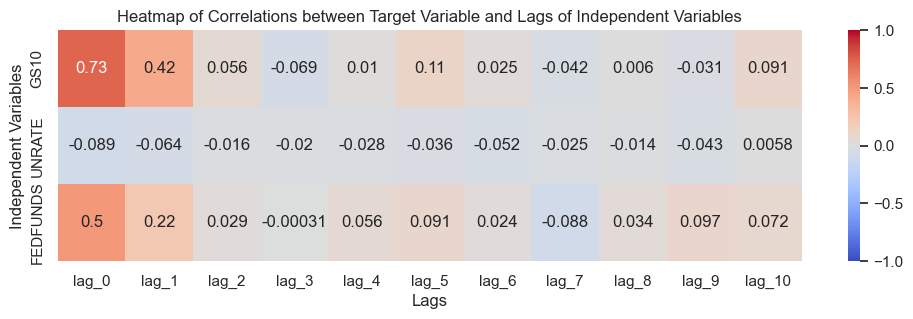

In [ ]:
target_var = 'MORTGAGE30US'
independent_vars = ['GS10', 'UNRATE', 'FEDFUNDS']
plot_heatmap_correlations(df_diff, target_col=target_var, independent_vars=independent_vars, num_lags=10)

**Step 2: Reasoning**

#### Colinearity

#### Cointegration

**Step 1: Compute Cointegration Test**

In [ ]:
# Function to calculate cointegration for each pair of variables in a DataFrame
def calculate_cointegration(dataframe, test="Engle-Granger", threshold=0.05):
    coint_df = pd.DataFrame(columns=['Variable 1', 'Variable 2', 'Test', 'p-value', 'Threshold', 'Pass/Fail', 'Decision'])
    for i in range(len(dataframe.columns)):
        for j in range(i+1, len(dataframe.columns)):
            var1 = dataframe.columns[i]
            var2 = dataframe.columns[j]
            _, p_value, _ = coint(dataframe[var1], dataframe[var2])
            pass_fail = "Pass" if p_value <= threshold else "Fail"
            decision = "Cointegrated" if pass_fail == "Pass" else "Not Cointegrated"
            coint_df = coint_df.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Test': test,
                'p-value': p_value,
                'Threshold': threshold,
                'Pass/Fail': pass_fail,
                'Decision': decision
            }, ignore_index=True)
    return coint_df

In [ ]:
# Calculate cointegration for pairs of variables in the DataFrame
coint_results = calculate_cointegration(df)
display(coint_results)

,Variable 1,Variable 2,Test,p-value,Threshold,Pass/Fail,Decision
0,MORTGAGE30US,UNRATE,Engle-Granger,0.627876,0.05,Fail,Not Cointegrated
1,MORTGAGE30US,GS10,Engle-Granger,0.008688,0.05,Pass,Cointegrated
2,MORTGAGE30US,FEDFUNDS,Engle-Granger,0.020417,0.05,Pass,Cointegrated
3,UNRATE,GS10,Engle-Granger,0.013242,0.05,Pass,Cointegrated
4,UNRATE,FEDFUNDS,Engle-Granger,0.027579,0.05,Pass,Cointegrated
5,GS10,FEDFUNDS,Engle-Granger,0.005832,0.05,Pass,Cointegrated


**Step 2: Plot Spread between Variables**

In [ ]:
# Function to plot the spread between all pairs of variables in a DataFrame
def plot_spread(dataframe):
    num_vars = len(dataframe.columns)
    
    for i in range(num_vars):
        for j in range(i+1, num_vars):
            var1 = dataframe.columns[i]
            var2 = dataframe.columns[j]

            # Calculate the spread between the two variables
            dataframe['spread'] = dataframe[var1] - dataframe[var2]

            # Plot the difference (spread) using seaborn
            plt.figure(figsize=(10, 4))
            sns.lineplot(data=dataframe['spread'], label=f'Spread ({var1} - {var2})')
            plt.title(f'Spread ({var1} - {var2})')
            plt.legend()

            # Display the plot
            plt.tight_layout()
            plt.show()


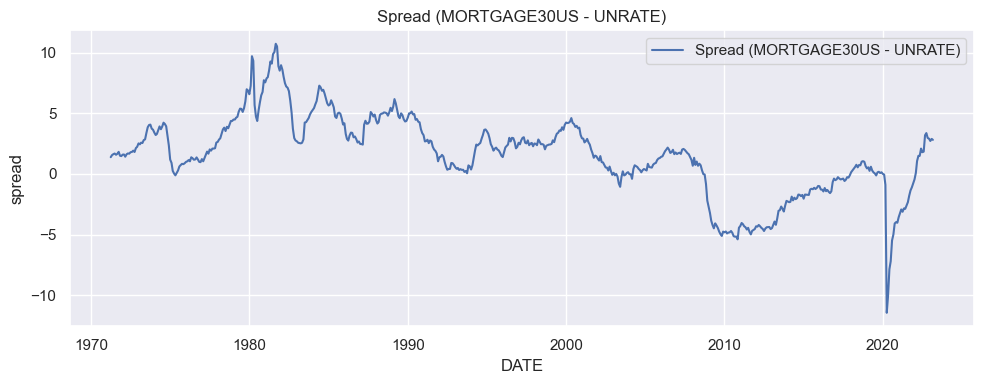

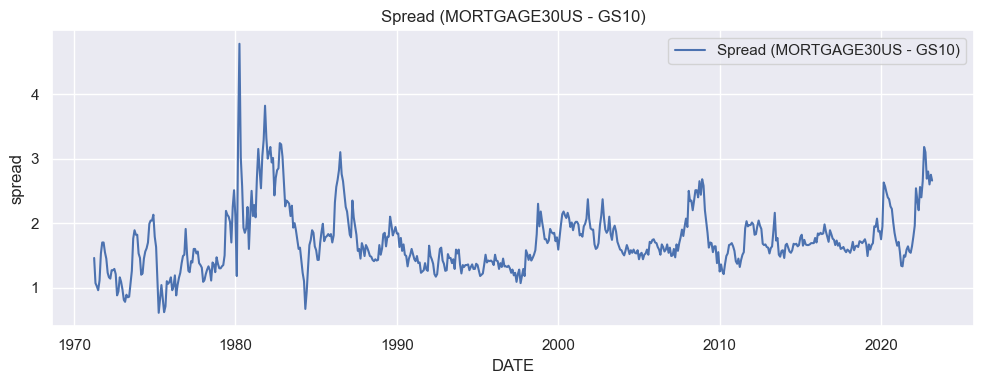

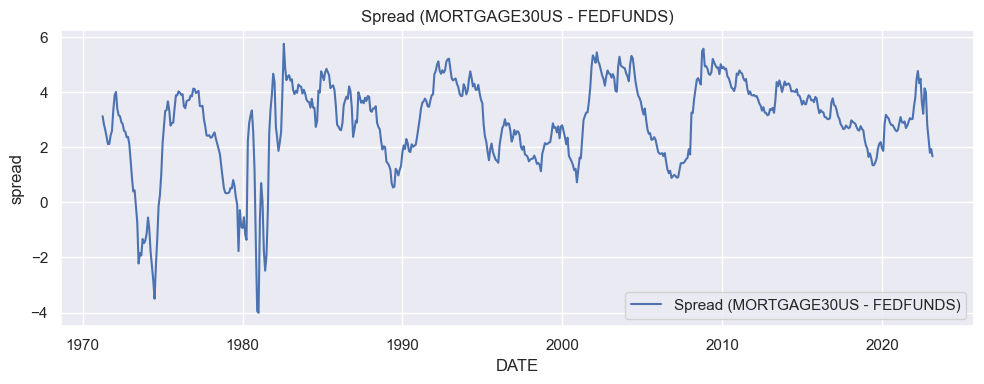

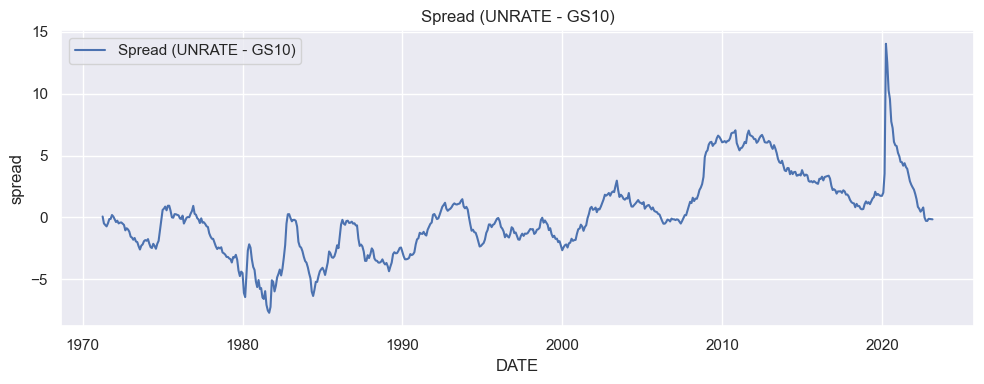

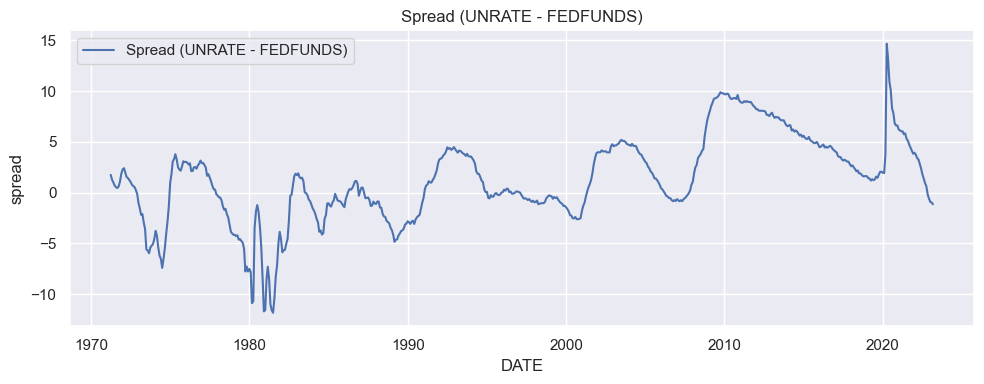

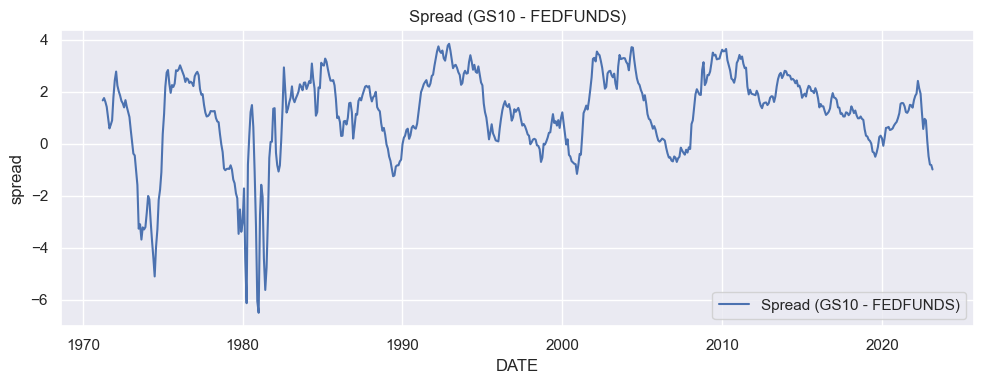

In [ ]:
plot_spread(df)

### 4.2.3. Feature Selection

## 4.3. Model Methodology

## 4.4. Training Data

### 4.4.1. Sampling 

**Step 1: Split dataset into Training and Test**

In [ ]:
split_index = int(len(df) * 0.8)   # use 80% of the data for training
df_train, df_test = df[:split_index], df[split_index:]

**Step 2: Create a Stationary Train and Test Dataset**

In [ ]:
# Apply first difference to both training and test df
df_train_diff = df_train.diff().dropna()
df_test_diff = df_test.diff().dropna()

In [1]:
df_train_diff.head()

NameError: name 'df_train_diff' is not defined

## 4.5. Model Training

### Model 1: Loan Rates and FEDFUNDS

**Step 1: Fit Model**

In [47]:
# Add the independent variables with no intercept
X = df_train_diff['FEDFUNDS']

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_1 = sm.OLS(y, X).fit()

# Display the model summary
print(model_1.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.286
Model:                            OLS   Adj. R-squared (uncentered):              0.284
Method:                 Least Squares   F-statistic:                              198.8
Date:                Sat, 06 May 2023   Prob (F-statistic):                    3.22e-38
Time:                        16:41:11   Log-Likelihood:                         -57.220
No. Observations:                 498   AIC:                                      116.4
Df Residuals:                     497   BIC:                                      120.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Step 2: Reasoning**

### Model 2: Loan Rates, constant and FEDFUNDS

**Step 1: Fit Model**

In [48]:
# Add a constant to the independent variables for the linear regression model
X = sm.add_constant(df_train_diff['FEDFUNDS'])

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_2 = sm.OLS(y, X).fit()

# Display the model summary
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:           MORTGAGE30US   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     198.3
Date:                Sat, 06 May 2023   Prob (F-statistic):           3.99e-38
Time:                        16:41:11   Log-Likelihood:                -57.120
No. Observations:                 498   AIC:                             118.2
Df Residuals:                     496   BIC:                             126.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.012     -0.448      0.6

**Step 2: Reasoning**

### Model 3: Loan Rates and GS10

In [49]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff['GS10']

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_3 = sm.OLS(y, X).fit()

# Display the model summary
print(model_3.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              558.1
Date:                Sat, 06 May 2023   Prob (F-statistic):                    2.80e-83
Time:                        16:41:12   Log-Likelihood:                          46.439
No. Observations:                 498   AIC:                                     -90.88
Df Residuals:                     497   BIC:                                     -86.67
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Model 4: Loan Rates, FEDFUNDS and GS10

**Step 1: Fit Model**

In [50]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff[['GS10', 'FEDFUNDS']]

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_4 = sm.OLS(y, X).fit()

# Display the model summary
print(model_4.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.621
Model:                            OLS   Adj. R-squared (uncentered):              0.620
Method:                 Least Squares   F-statistic:                              407.0
Date:                Sat, 06 May 2023   Prob (F-statistic):                   2.45e-105
Time:                        16:41:12   Log-Likelihood:                          100.84
No. Observations:                 498   AIC:                                     -197.7
Df Residuals:                     496   BIC:                                     -189.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Step 2: Reasoning**

### Model 5: Loan Rates, FEDFUNDS, GS10 and UNRATE

**Step 1: Fit Model**

In [51]:
# Add a constant to the independent variables for the linear regression model
X = df_train_diff[['GS10', 'FEDFUNDS', 'UNRATE']]

# Define the dependent variable 
y = df_train_diff['MORTGAGE30US']

# Fit the linear regression model
model_5 = sm.OLS(y, X).fit()

# Display the model summary
print(model_5.summary())

                                 OLS Regression Results                                
Dep. Variable:           MORTGAGE30US   R-squared (uncentered):                   0.622
Model:                            OLS   Adj. R-squared (uncentered):              0.619
Method:                 Least Squares   F-statistic:                              271.0
Date:                Sat, 06 May 2023   Prob (F-statistic):                   4.91e-104
Time:                        16:41:18   Log-Likelihood:                          100.97
No. Observations:                 498   AIC:                                     -195.9
Df Residuals:                     495   BIC:                                     -183.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

#### Model Selection

**Step 1: In-Sample Performance**

In [52]:
def in_sample_performance_ols(models):
    evaluation_results = []

    for i, model in enumerate(models):
        X = model.model.exog
        X_columns = model.model.exog_names
        y = model.model.endog

        # Calculate the predicted values using the model
        y_pred = model.predict(X)

        # Calculate the residuals
        residuals = y - y_pred

        # Extract R-squared and Adjusted R-squared
        r2 = model.rsquared
        adj_r2 = model.rsquared_adj

        # Calculate the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
        mse = model.mse_resid
        rmse = mse ** 0.5

        # Append the results to the evaluation_results list
        evaluation_results.append({
            'Model': f'Model_{i + 1}',
            'Independent Variables': ', '.join(X_columns),
            'R-Squared': r2,
            'Adjusted R-Squared': adj_r2,
            'MSE': mse,
            'RMSE': rmse
        })

    # Convert the evaluation_results list to a DataFrame
    results_df = pd.DataFrame(evaluation_results)
    
    return results_df

In [53]:
models = [model_1, model_2, model_3, model_4, model_5]
results_df = in_sample_performance_ols(models)
display(results_df)


,Model,Independent Variables,R-Squared,Adjusted R-Squared,MSE,RMSE
0,Model_1,FEDFUNDS,0.285734,0.284296,0.073824,0.271706
1,Model_2,"const, FEDFUNDS",0.285602,0.284162,0.073943,0.271925
2,Model_3,GS10,0.528954,0.528007,0.048686,0.220649
3,Model_4,"GS10, FEDFUNDS",0.621400,0.619873,0.039210,0.198015
4,Model_5,"GS10, FEDFUNDS, UNRATE",0.621597,0.619304,0.039269,0.198163


**Step 2: In-Sample Forecast First Difference**

In [54]:
def in_sample_forecast(models, observed_data, separate_subplots=False):
    # Extract the observed data and dates
    y = observed_data
    x = observed_data.index

    sns.set(style="darkgrid")

    if separate_subplots:
        # Calculate the number of rows and columns for the subplots
        n_models = len(models)
        n_cols = 2
        n_rows = n_models // n_cols + (n_models % n_cols > 0)

        # Set up the plot
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=True, sharey=True)
        axes = axes.ravel()

        # Plot the observed data and in-sample predictions for each model
        for i, model in enumerate(models):
            ax = axes[i]
            sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey', ax=ax)

            X = model.model.exog
            y_pred = model.predict(X)
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5, ax=ax)

            # Get the independent variable names
            ind_var_names = ', '.join(model.model.exog_names)

            ax.set_title(f'Model_{i + 1} ({ind_var_names})')
            ax.legend()

        # Remove unused subplots
        for j in range(i+1, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Customize the plot
        fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

    else:
        # Set up the plot
        plt.figure(figsize=(10, 6))

        # Plot the observed data
        sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey')

        # Plot the in-sample predictions for each model
        for i, model in enumerate(models):
            X = model.model.exog
            y_pred = model.predict(X)
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5)

        # Customize the plot
        plt.ylabel('Value')
        plt.title('Observed Data and In-sample Predictions')
        plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


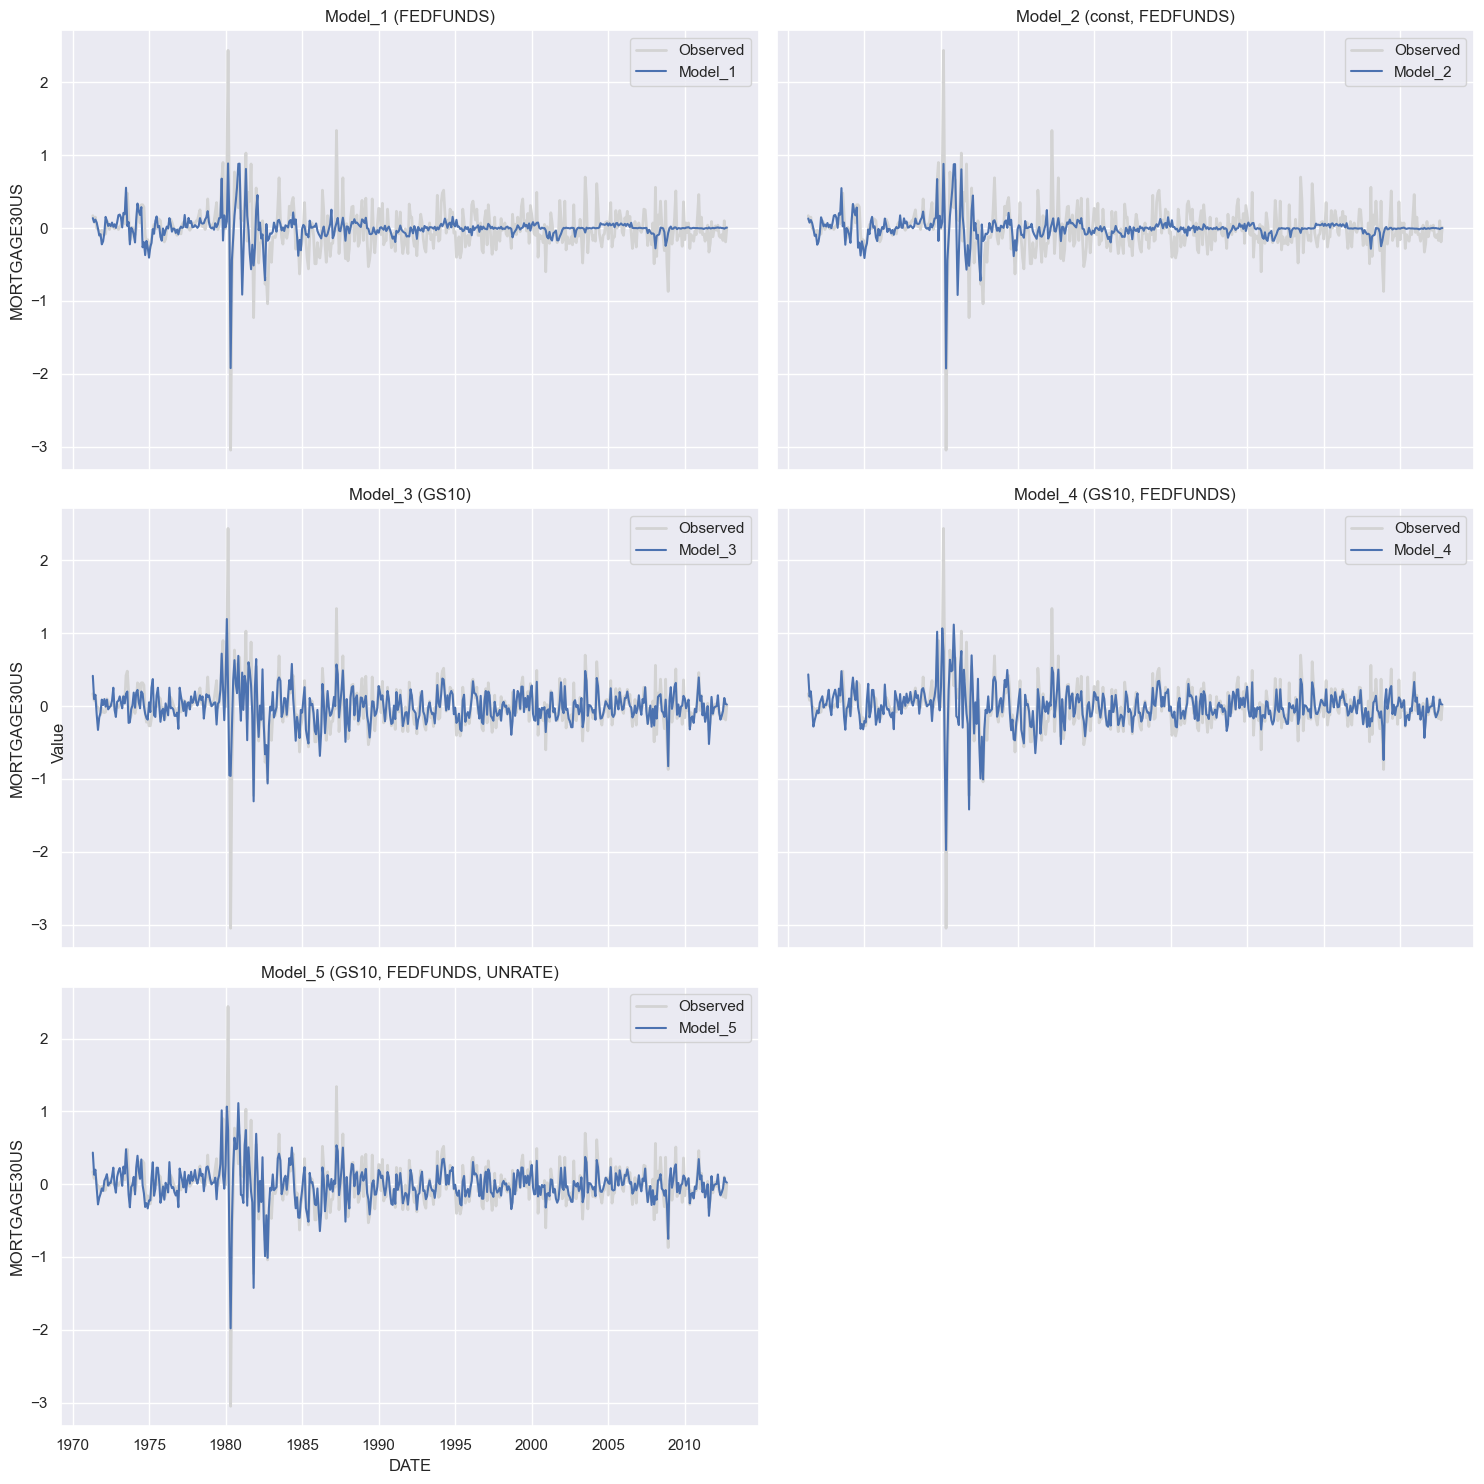

In [55]:
models = [model_1, model_2, model_3, model_4, model_5]
observed_data = df_train_diff['MORTGAGE30US']
in_sample_forecast(models, observed_data, separate_subplots=True)  # For separate subplots

**Step 3: In-Sample Forecast Levels**

In [56]:
def in_sample_forecast_levels(models, original_data, diff_data, separate_subplots=False):
    # Extract the observed data (levels) and dates
    y = original_data
    x = original_data.index

    sns.set(style="darkgrid")

    if separate_subplots:
        # Calculate the number of rows and columns for the subplots
        n_models = len(models)
        n_cols = 2
        n_rows = n_models // n_cols + (n_models % n_cols > 0)

        # Set up the plot
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=True, sharey=True)
        axes = axes.ravel()

        # Plot the observed data (levels) and in-sample predictions for each model
        for i, model in enumerate(models):
            ax = axes[i]
            sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey', ax=ax)

            X = model.model.exog
            y_diff_pred = model.predict(X)
            y_pred = np.concatenate(([y.iloc[0]], y.iloc[0] + np.cumsum(y_diff_pred)))
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5, ax=ax)

            # Get the independent variable names
            ind_var_names = ', '.join(model.model.exog_names)

            ax.set_title(f'Model_{i + 1} ({ind_var_names})')
            ax.legend()

        # Remove unused subplots
        for j in range(i+1, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Customize the plot
        fig.text(0.5, 0.04, 'DATE', ha='center')
        fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

    else:
        # Set up the plot
        plt.figure(figsize=(10, 6))

        # Plot the observed data (levels)
        sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey')

        # Plot the in-sample predictions for each model
        for i, model in enumerate(models):
            X = model.model.exog
            y_diff_pred = model.predict(X)
            y_pred = np.concatenate(([y.iloc[0]], y.iloc[0] + np.cumsum(y_diff_pred)))
            sns.lineplot(x=x, y=y_pred, label=f'Model_{i + 1}', linewidth=1.5)

        # Customize the plot
        plt.xlabel('DATE')
        plt.ylabel('Value')
        plt.title('Observed Data and In-sample Predictions (Levels)')
        plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()



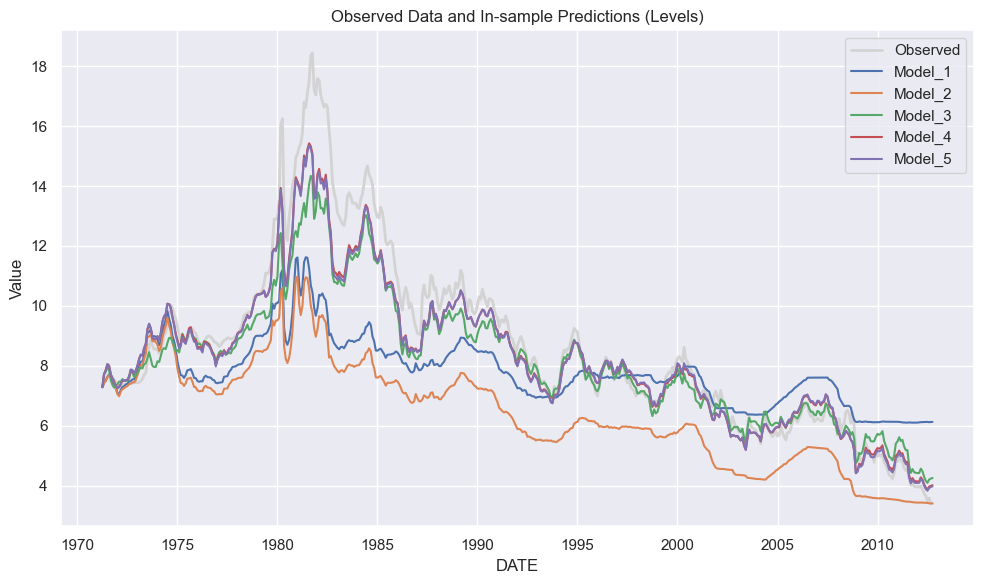

In [57]:
models = [model_1, model_2, model_3, model_4, model_5]
original_data = df_train['MORTGAGE30US']
diff_data = df_train_diff['MORTGAGE30US']
in_sample_forecast_levels(models, original_data, diff_data, separate_subplots=False)  # For a single plot with all series


## 4.6. Model Evaluation

### 4.6.1. Out-of-Sample Analysis

#### Out-of-Sample Performance

In [90]:
def out_of_sample_performance(model_list, model_names, test_data, target_col):
    # Initialize a list to store results
    results = []

    for fitted_model, model_name in zip(model_list, model_names):
        # Extract the column names of the independent variables from the model
        independent_vars = fitted_model.model.exog_names

        # Separate the target variable and features in the test dataset
        X_test = test_data[independent_vars]
        y_test = test_data[target_col]

        # Predict the test data
        y_pred = fitted_model.predict(X_test)

        # Calculate the residuals
        residuals = y_test - y_pred

        # Calculate the mean squared error and root mean squared error
        mse = np.mean(residuals ** 2)
        rmse_val = np.sqrt(mse)

        # Store the results
        model_name_with_vars = f"{model_name} ({', '.join(independent_vars)})"
        results.append([model_name_with_vars, mse, rmse_val])

    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'RMSE'])

    return results_df


In [91]:
model_list = [model_3, model_4]
model_names = ['model_3', 'model_4']
results_df = out_of_sample_performance(model_list, model_names=model_names, test_data=df_test_diff, target_col='MORTGAGE30US')
display(results_df)

,Model,MSE,RMSE
0,model_3 (GS10),0.024310,0.155916
1,"model_4 (GS10, FEDFUNDS)",0.027384,0.165482


#### Out-of-Sample Forecast

In [83]:
def out_of_sample_forecast(models, model_names, test_data, target_col, separate_subplots=False):
    # Extract the observed data and dates
    y = test_data[target_col]
    x = test_data.index

    sns.set(style="darkgrid")

    if separate_subplots:
        # Calculate the number of rows and columns for the subplots
        n_models = len(models)
        n_cols = 2
        n_rows = n_models // n_cols + (n_models % n_cols > 0)

        # Set up the plot
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=True, sharey=True)
        axes = axes.ravel()

        # Plot the observed data and out-of-sample predictions for each model
        for i, model in enumerate(models):
            ax = axes[i]
            sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey', ax=ax)

            exog_names = model.model.exog_names
            if 'const' in exog_names and 'const' not in test_data.columns:
                X_test = test_data[[name for name in exog_names if name != 'const']]
                X_test.insert(0, 'const', 1)
            else:
                X_test = test_data[exog_names]

            y_pred = model.predict(X_test)
            sns.lineplot(x=x, y=y_pred, label=f'{model_names[i]}', linewidth=1.5, ax=ax)

            ax.set_title(f'{model_names[i]} ({", ".join(exog_names)})')
            ax.legend()

        # Remove unused subplots
        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Customize the plot
        fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

    else:
        # Set up the plot
        plt.figure(figsize=(10, 6))

        # Plot the observed data
        sns.lineplot(x=x, y=y, label='Observed', linewidth=2, color='lightgrey')

        # Plot the out-of-sample predictions for each model
        for i, model in enumerate(models):
            exog_names = model.model.exog_names
            if 'const' in exog_names and 'const' not in test_data.columns:
                X_test = test_data[[name for name in exog_names if name != 'const']]
                X_test.insert(0, 'const', 1)
            else:
                X_test = test_data[exog_names]

            y_pred = model.predict(X_test)
            sns.lineplot(x=x, y=y_pred, label=f'{model_names[i]}', linewidth=1.5)

        # Customize the plot
        plt.ylabel('Value')
        plt.title('Observed Data and Out-of-sample Predictions')
        plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


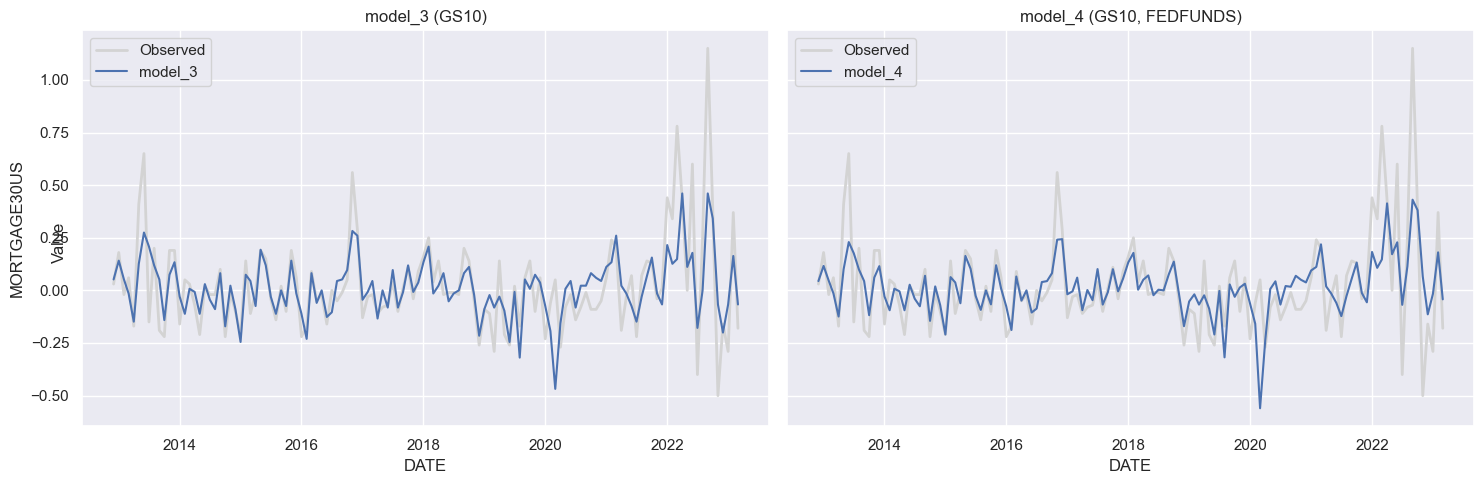

In [85]:
models = [model_3, model_4]
out_of_sample_forecast(models, model_names=['model_3', 'model_4'], test_data=df_test_diff, target_col='MORTGAGE30US', separate_subplots=True)

In [100]:
def out_of_sample_forecast_levels(models, model_names, test_data, original_data, target_col, separate_subplots=False):
    # Extract the observed data and dates
    y_test = test_data[target_col]
    y_orig = original_data[original_data.index.isin(test_data.index)][target_col]
    x = y_orig.index

    sns.set(style="darkgrid")

    if separate_subplots:
        # Calculate the number of rows and columns for the subplots
        n_models = len(models)
        n_cols = 2
        n_rows = n_models // n_cols + (n_models % n_cols > 0)

        # Set up the plot
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5), sharex=True, sharey=True)
        axes = axes.ravel()

        # Plot the observed data and out-of-sample predictions for each model
        for i, model in enumerate(models):
            ax = axes[i]
            sns.lineplot(x=x, y=y_orig, label='Observed', linewidth=2, color='lightgrey', ax=ax)

            exog_names = model.model.exog_names
            if 'const' in exog_names and 'const' not in test_data.columns:
                X_test = test_data[[name for name in exog_names if name != 'const']]
                X_test.insert(0, 'const', 1)
            else:
                X_test = test_data[exog_names]

            y_pred_diff = model.predict(X_test)
            y_pred = y_pred_diff + y_orig.shift(1).values
            sns.lineplot(x=x, y=y_pred, label=f'{model_names[i]}', linewidth=1.5, ax=ax)

            ax.set_title(f'{model_names[i]} ({", ".join(exog_names)})')
            ax.legend()

        # Remove unused subplots
        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes[j])

        # Customize the plot
        fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

    else:
        # Set up the plot
        plt.figure(figsize=(10, 6))

        # Plot the observed data
        sns.lineplot(x=x, y=y_orig, label='Observed', linewidth=2, color='lightgrey')

        # Plot the out-of-sample predictions for each model
        for i, model in enumerate(models):
            exog_names = model.model.exog_names
            if 'const' in exog_names and 'const' not in test_data.columns:
                X_test = test_data[[name for name in exog_names if name != 'const']]
                X_test.insert(0, 'const', 1)
            else:
                X_test = test_data[exog_names]

            y_pred_diff = model.predict(X_test)
            y_pred = y_pred_diff + y_orig.shift(1).values
            sns.lineplot(x=x, y=y_pred, label=f'{model_names[i]}', linewidth=1.5)

        # Customize the plot
        plt.ylabel('Value')
        plt.title('Observed Data and Out-of-sample Predictions')
        plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()



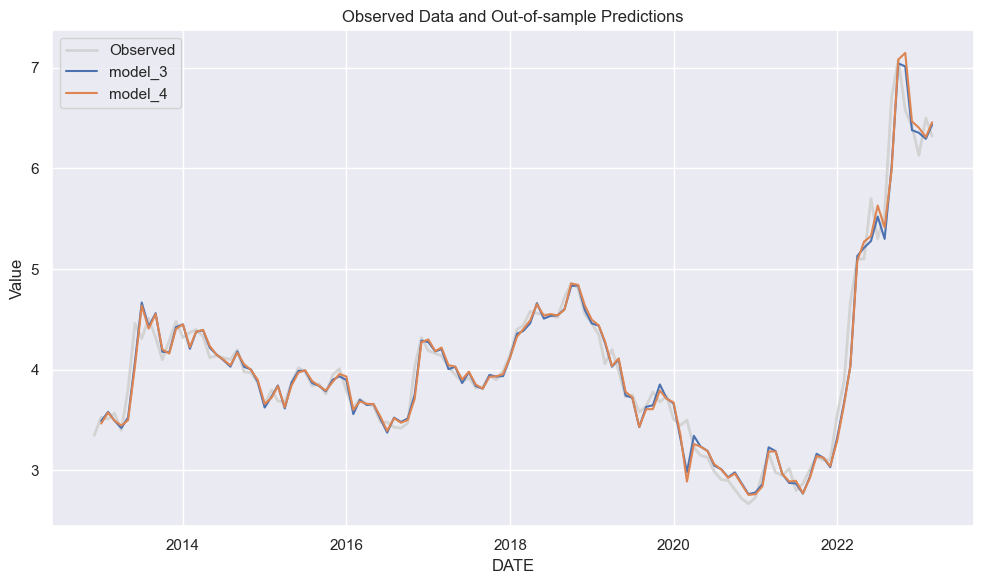

In [101]:
models = [model_3, model_4]
model_names = ['model_3', 'model_4']
original_data = df_test
out_of_sample_forecast_levels(models, model_names, test_data=df_test_diff, original_data=original_data, target_col='MORTGAGE30US', separate_subplots=False)

### 4.6.2. Forecast Performance 

#### One-Step Ahead Forecast 

#### Five-Step Ahead Forecast 

### 4.6.3. Scenario Analysis

#### Parallel Interest Rates Shocks 

### 4.6.4. Stress Testing

### 4.6.5. Uncertainty Analysis